In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
import pandas as pd
import io
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import netCDF4 as nc

In [3]:
dhw_mon = xr.open_dataset('./dhw_monthly.nc')
dhw_mon = dhw_mon.rename({'longitude': 'lon','latitude': 'lat'})
dhw_mon = dhw_mon.reindex(lat=list(reversed(dhw_mon.lat)))
dhw_mon.lat,dhw_mon.lon

(<xarray.DataArray 'lat' (lat: 920)>
 array([-15.975, -15.925, -15.875, ...,  29.875,  29.925,  29.975],
       dtype=float32)
 Coordinates:
   * lat      (lat) float32 -15.98 -15.93 -15.88 -15.82 ... 29.88 29.92 29.98
 Attributes:
     _CoordinateAxisType:    Lat
     actual_range:           [-89.975  89.975]
     axis:                   Y
     comment:                equirectangular projection and grid centers
     coverage_content_type:  coordinate
     ioos_category:          Location
     long_name:              Latitude
     standard_name:          latitude
     units:                  degrees_north
     valid_max:              89.975
     valid_min:              -89.975,
 <xarray.DataArray 'lon' (lon: 1280)>
 array([143.025, 143.075, 143.125, ..., 206.875, 206.925, 206.975],
       dtype=float32)
 Coordinates:
   * lon      (lon) float32 143.0 143.1 143.1 143.2 ... 206.8 206.9 206.9 207.0
 Attributes:
     _CoordinateAxisType:    Lon
     actual_range:           [  0.025 359.975

In [4]:
lon_min = 143.
lon_max = 207.
lat_min = -16.
lat_max = 30.
mask = xr.open_dataset('./PI_all_mask.nc')
mask.coords['lon'] = np.mod(mask['lon'], 360)
mask = mask.sortby(mask.lon).sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))

mask.lat,mask.lon

(<xarray.DataArray 'lat' (lat: 920)>
 array([-15.975, -15.925, -15.875, ...,  29.875,  29.925,  29.975])
 Coordinates:
   * lat      (lat) float64 -15.97 -15.92 -15.87 -15.82 ... 29.88 29.93 29.98,
 <xarray.DataArray 'lon' (lon: 1280)>
 array([143.025, 143.075, 143.125, ..., 206.875, 206.925, 206.975])
 Coordinates:
   * lon      (lon) float64 143.0 143.1 143.1 143.2 ... 206.8 206.9 206.9 207.0)

In [13]:
mk = mask.region_mask.where(mask.region_mask==0,1)
mk = mk.where(mk!=0,np.nan)
np.nansum(mk.values)#.nansum()#.shape #.sum()
mk

<xarray.DataArray 'region_mask' (lat: 920, lon: 1280)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -15.97 -15.92 -15.87 -15.82 ... 29.88 29.93 29.98
  * lon      (lon) float64 143.0 143.1 143.1 143.2 ... 206.8 206.9 206.9 207.0

In [14]:
dhw_mon_masked = dhw_mon * (mk.values)
dhw_mon_masked

<xarray.Dataset>
Dimensions:  (time: 471, lat: 920, lon: 1280)
Coordinates:
  * time     (time) datetime64[ns] 1985-03-16T12:00:00 ... 2024-05-16T12:00:00
  * lat      (lat) float32 -15.98 -15.93 -15.88 -15.82 ... 29.88 29.92 29.98
  * lon      (lon) float32 143.0 143.1 143.1 143.2 ... 206.8 206.9 206.9 207.0
Data variables:
    sst      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [15]:
total_pt = dhw_mon_masked.where(np.isnan(dhw_mon_masked.sst),1).sum(('lat','lon'))

In [16]:
a = dhw_mon_masked.where(dhw_mon_masked.sst>4,np.nan)
b = dhw_mon_masked.where(dhw_mon_masked.sst>8,np.nan)
dhw4 = a.where(np.isnan(a),1).sum(('lat','lon'))
dhw8 = b.where(np.isnan(b),1).sum(('lat','lon'))
del(dhw_mon_masked)

In [17]:
dhw8,total_pt

(<xarray.Dataset>
 Dimensions:  (time: 471)
 Coordinates:
   * time     (time) datetime64[ns] 1985-03-16T12:00:00 ... 2024-05-16T12:00:00
 Data variables:
     sst      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 10.0 10.0 6.0 48.0 48.0,
 <xarray.Dataset>
 Dimensions:  (time: 471)
 Coordinates:
   * time     (time) datetime64[ns] 1985-03-16T12:00:00 ... 2024-05-16T12:00:00
 Data variables:
     sst      (time) float64 587.0 587.0 587.0 587.0 ... 587.0 587.0 587.0 587.0)

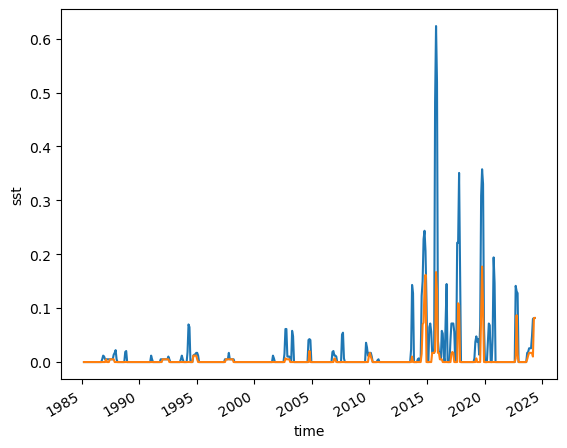

In [18]:
#mean = dhw_mon_masked.sst.mean(('time'))
#mean.where(np.isnan(mean),1).sum()

per_dhw4 = dhw4/total_pt
per_dhw8 = dhw8/total_pt

per_dhw4.sst.plot()
per_dhw8.sst.plot()

In [5]:
region = mask.index.where(mask.region_name=='SAMOA')
region = region[~np.isnan(region)]
AS = region.values
region = mask.index.where(mask.region_name=='MARIAN')[-10:]
region = region[~np.isnan(region)]
GM = region.values
region = mask.index.where(mask.region_name=='MARIAN')[:40]
region = region[~np.isnan(region)]
MA = region.values
region = mask.index.where(mask.region_name=='MHI')
region = region[~np.isnan(region)]
region2 = mask.index.where(mask.region_name=='NWHI')
region2 = region2[~np.isnan(region2)]
MHI = np.concatenate([region2,region])

region = mask.index.where(mask.region_name=='PRIA')[:7]
region = region[~np.isnan(region)]
HB = region.values

region = mask.index.where(mask.region_name=='PRIA')[7:8]
region = region[~np.isnan(region)]
JA = region.values
region = mask.index.where(mask.region_name=='PRIA')[14:18]
region = region[~np.isnan(region)]
WK = region.values
region = mask.index.where(mask.region_name=='PRIA')[8:14]
region = region[~np.isnan(region)]
PL = region.values
region = mask.index.where(mask.region_name=='PRIA')[19:27]
region = region[~np.isnan(region)]
JS = region.values
MHI,JS

(array([ 5.,  9., 10., 11., 12., 26., 29., 30., 31., 32., 33., 34., 35.,
        36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48.,
        49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61.,
        62., 63., 64., 65.]),
 array([27.]))

In [10]:
List = [AS,GM,MHI,HB,JA,JS,MA,PL,WK]

List_name = ['American Samoa', 'Guam','Hawaii','Howland and Baker islands',
             'Jarvis island','Johnston Atoll','Northern Mariana Islands','Palmyra Atoll','Wake Atoll']


[13. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81.]
American Samoa
13.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
American Samoa


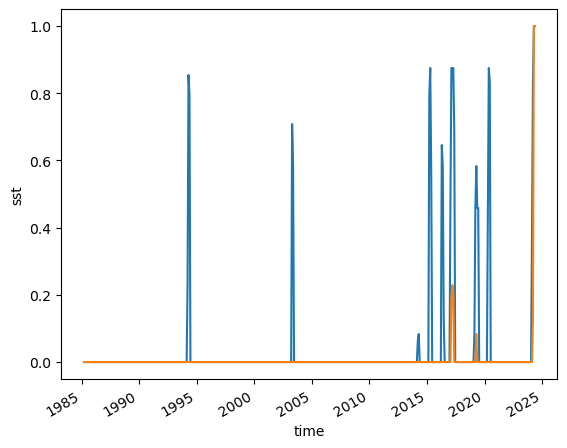

[82. 83. 84. 85. 86. 87. 88. 89.]
Guam
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
Guam


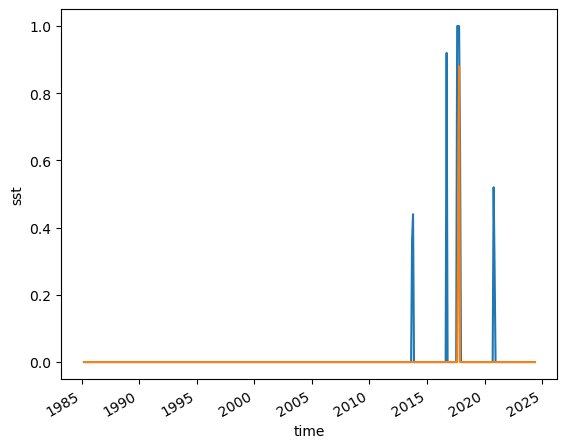

[ 5.  9. 10. 11. 12. 26. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40.
 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58.
 59. 60. 61. 62. 63. 64. 65.]
Hawaii
5.0
9.0
10.0
11.0
12.0
26.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
Hawaii


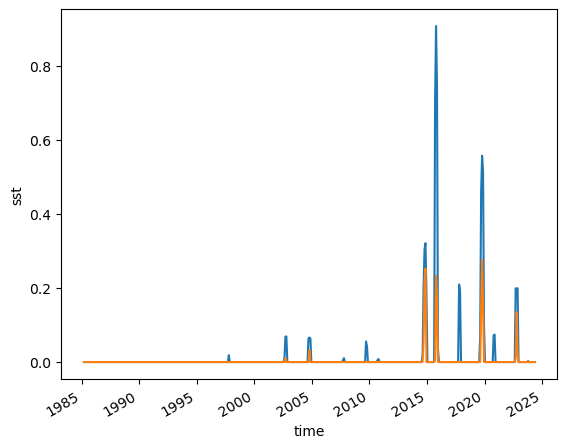

[3. 7.]
Howland and Baker islands
3.0
7.0
Howland and Baker islands


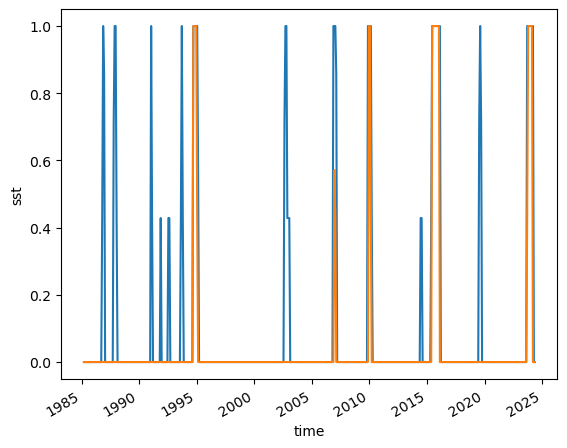

[8.]
Jarvis island
8.0
Jarvis island


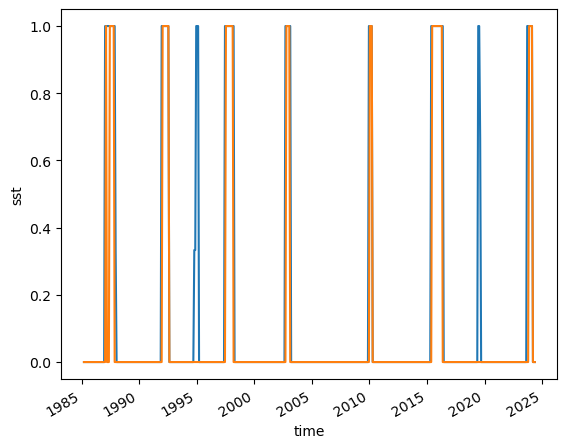

[27.]
Johnston Atoll
27.0
Johnston Atoll


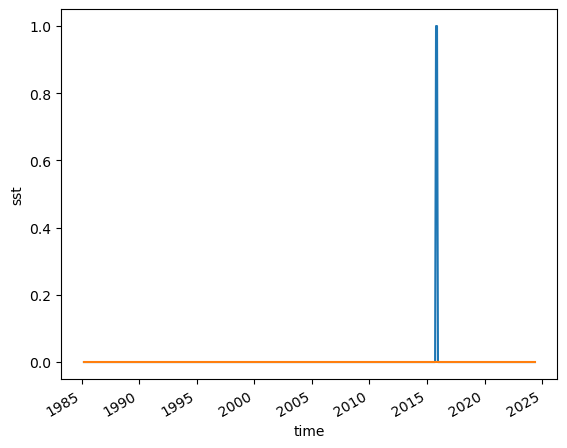

[ 1.  2.  4.  6. 15. 16. 17. 19. 20. 21. 22. 23. 24. 25.]
Northern Mariana Islands
1.0
2.0
4.0
6.0
15.0
16.0
17.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
Northern Mariana Islands


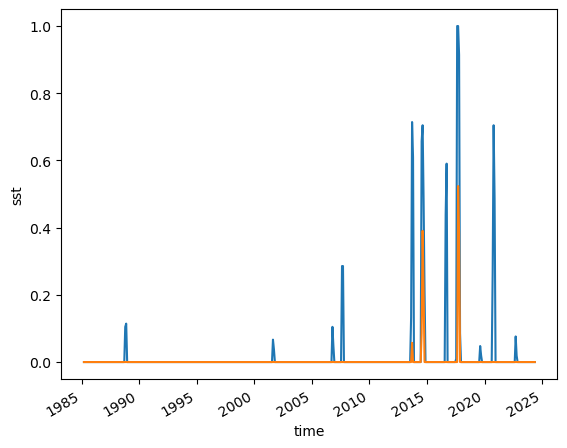

[14.]
Palmyra Atoll
14.0
Palmyra Atoll


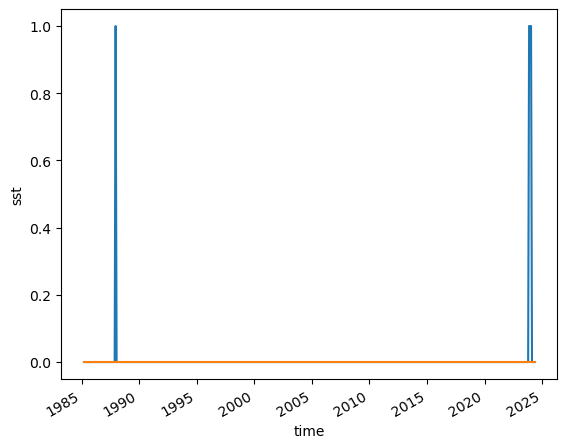

[18.]
Wake Atoll
18.0
Wake Atoll


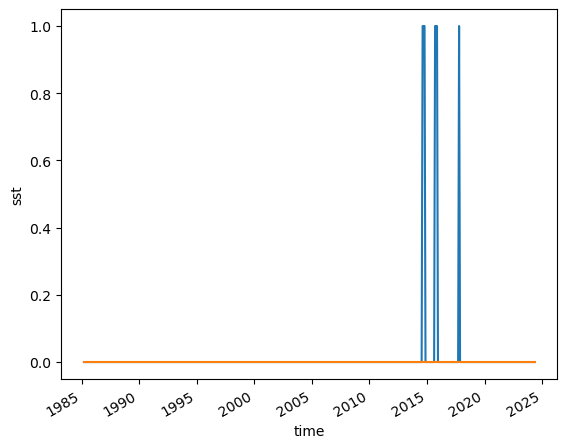

In [12]:
all_per_dhw4=[]
all_per_dhw8=[]

for j,region in enumerate(List):
    print(region)
    print(List_name [j])
    
    r_total=0
    r_dhw4=0
    r_dhw8=0

    for i,ind in enumerate(region):
        print(ind)
        region_mk = (mask.region_mask.where(mask.region_mask==ind))/ind
        region_mk
        temp_masked = dhw_mon* (region_mk.values)
    
        temp_total = temp_masked.where(np.isnan(temp_masked.sst),1).sum(('lat','lon'))
    
        a = temp_masked.where(temp_masked.sst>4,np.nan)
        b = temp_masked.where(temp_masked.sst>8,np.nan)
        temp_dhw4 = a.where(np.isnan(a),1).sum(('lat','lon'))
        temp_dhw8 = b.where(np.isnan(b),1).sum(('lat','lon'))
        r_total=r_total+temp_total
        r_dhw4=r_dhw4+temp_dhw4
        r_dhw8=r_dhw8+temp_dhw8
        
        del(temp_masked)
        del(temp_total)
        del(temp_dhw4)
        del(temp_dhw8)
    
        #fig=plt.figure(figsize=(6,4),dpi=150)
        #plt.contourf(mask.lon,mask.lat,mask.region_mask.where(mask.region_mask==ind), alpha=0.7, cmap='tab20', vmin=-5, vmax=90)  #.where(ds_mask.region_mask==1)
        #plt.colorbar()
        #plt.ylabel('Latitude')
        #plt.xlabel('Longitude')
    r_per_dhw4 = r_dhw4/r_total
    r_per_dhw8 = r_dhw8/r_total
    
    print(List_name [j])
    r_per_dhw4.sst.plot()
    r_per_dhw8.sst.plot()
    plt.show()
    
    all_per_dhw4.append(r_per_dhw4)
    all_per_dhw8.append(r_per_dhw8)
    del(r_per_dhw4)
    del(r_per_dhw8)


In [36]:
fig_title = ['American Samoa', 'Guam','Hawaii','Howland and Baker islands',
             'Jarvis island','Johnston Atoll','Northern Mariana Islands','Palmyra Atoll','Wake Atoll','Pacific NCRMP']


In [19]:
all_per_dhw4.append(per_dhw4)
all_per_dhw8.append(per_dhw8)

In [24]:
all_per_dhw4[i]

<xarray.Dataset>
Dimensions:  (time: 471)
Coordinates:
  * time     (time) datetime64[ns] 1985-03-16T12:00:00 ... 2024-05-16T12:00:00
Data variables:
    sst      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.375 0.8333 1.0 1.0

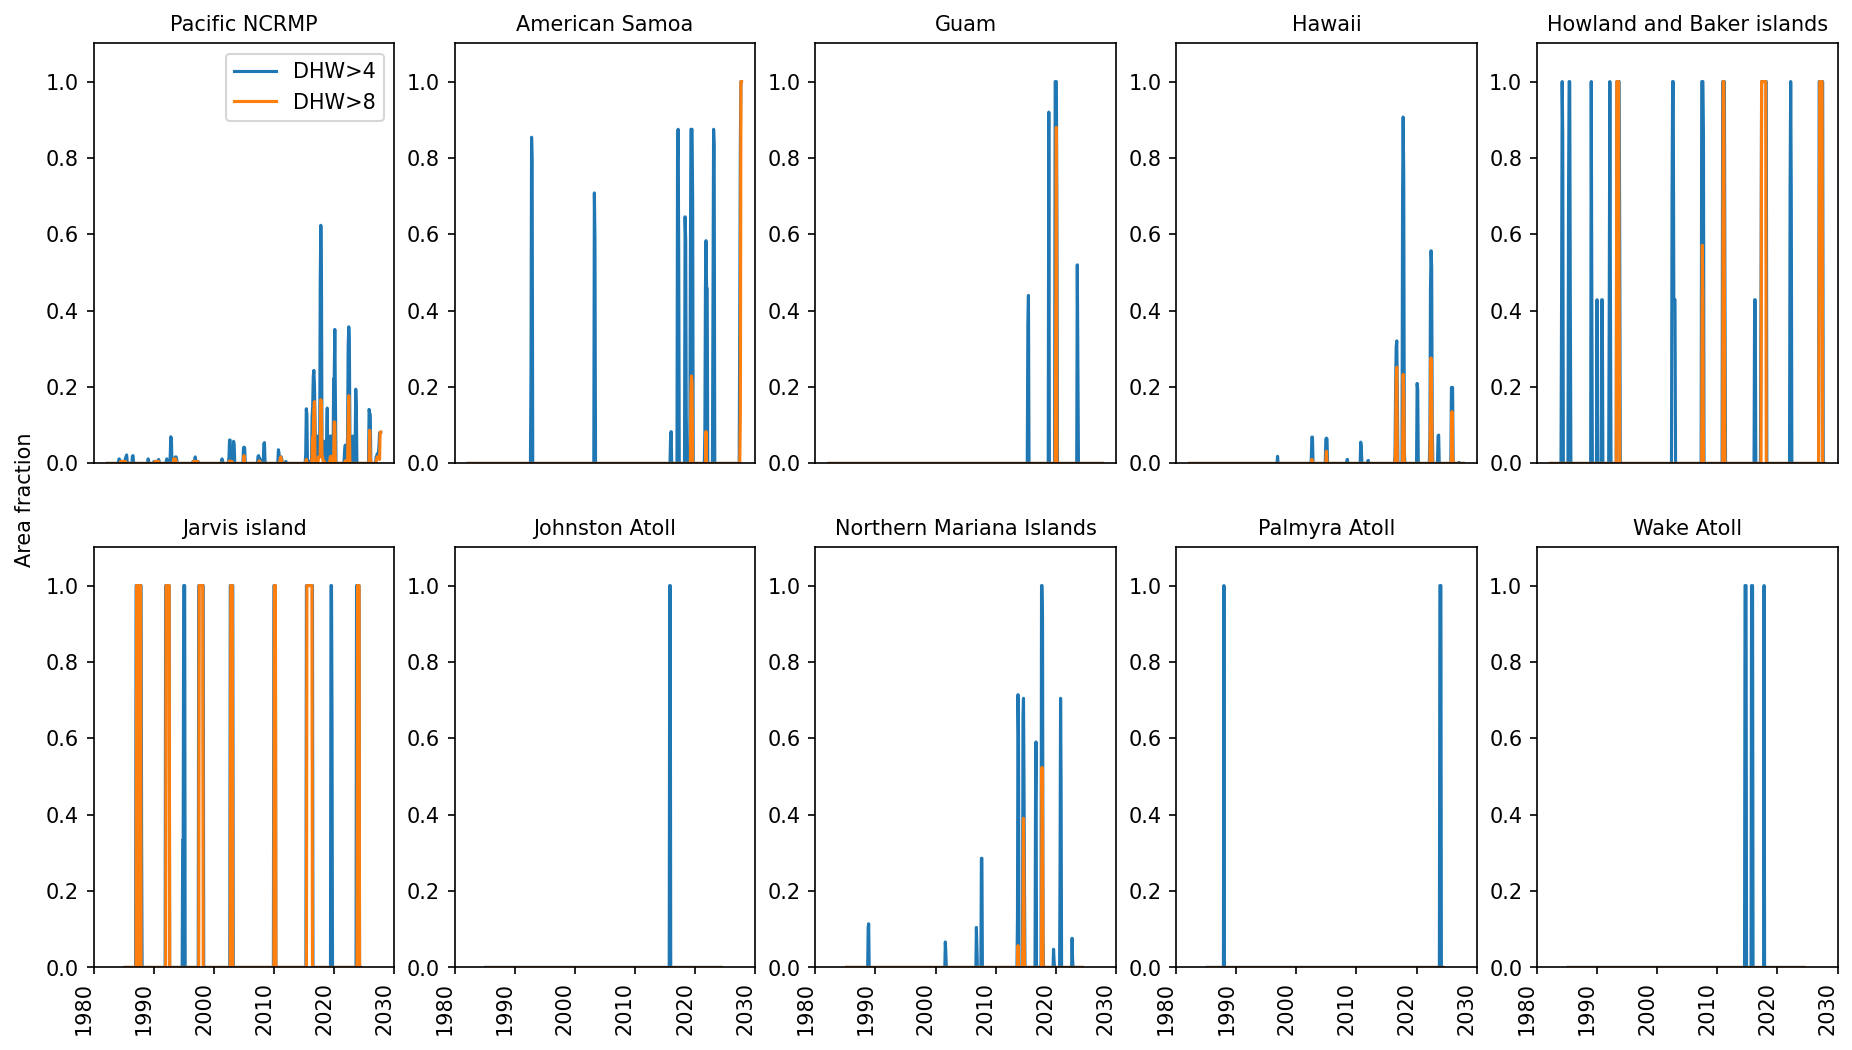

In [102]:
#fig = plt.figure(figsize=150)
import matplotlib.dates as mdates
fig, axs = plt.subplots(2, 5, figsize=(15, 8), dpi=150)

for i in range(0,10):
    ts = all_per_dhw4[i]
    ts1= all_per_dhw8[i]
    if i <=3:
        axs[0, i+1].plot(ts.time,ts.sst)
        axs[0, i+1].plot(ts1.time,ts1.sst)
        axs[0, i+1].set_title(fig_title[i],fontsize=10)
        axs[0, i+1].get_xaxis().set_ticks([])

        #axs[0, i+1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        #axs[0, i+1].set_xticks(axs[0, i+1].get_xticks()[::2])
        #axs[0, i+1].set_xticklabels(axs[0, i+1].get_xticklabels(), rotation=90, ha='right')

    if i >3 and i <9:
        axs[1, i-4].plot(ts.time,ts.sst)
        axs[1, i-4].plot(ts1.time,ts1.sst)
        axs[1, i-4].set_title(fig_title[i],fontsize=10)
        # Text in the x-axis will be displayed in 'YYYY-mm' format.
        axs[1, i-4].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        axs[1, i-4].set_xticks(axs[1, i-4].get_xticks()[::2])
        axs[1, i-4].set_xticklabels(axs[1, i-4].get_xticklabels(), rotation=90, ha='right')

        #if i == 4:
        #    axs[1, i-4].set_ylabel('Area fraction') 
    if i ==9:
        axs[0, 0].plot(ts.time,ts.sst, label='DHW>4')
        axs[0, 0].plot(ts1.time,ts1.sst, label='DHW>8')
        axs[0,0].set_title(fig_title[i],fontsize=10)
        axs[0,0].legend()
        #axs[0,0].set_ylabel('Area fraction') 
        # Text in the x-axis will be displayed in 'YYYY-mm' format.
        #axs[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        #axs[0,0].set_xticks(axs[0,0].get_xticks()[::2])
        #axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=90, ha='right')
        axs[0,0].get_xaxis().set_ticks([])
        

custom_ylim = (0, 1.1)
plt.setp(axs, ylim=custom_ylim)  #

fig.text(0.09, 0.5, 'Area fraction', va='center', rotation='vertical', )

plt.show()